In [1]:
import project_path

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

from src.text_split import extract_paragraphs, split_long_paragraphs, collapse_paragraphs_iteratively
from src.paths import datap

[nltk_data] Downloading package punkt to /home/justy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
tqdm.pandas()

In [3]:
dataset = pd.read_csv(datap("labeled_posts.csv"))

In [4]:
dataset.head()

,_id,body,label
0,W5taETbarXR9CQnEQ,\n\nOur programs exist to have a positive impa...,2.0
1,H8RrdDHGBLQHHopMj,\n\n## The most important century is the one w...,2.0
2,toDKgyu3HdzKyQHPb,\n\nMeet us at the Karbach Biergarten for an I...,2.0
3,Nb2HnrqG4nkjCqmRg,"\n\nDisclaimer: We (Sam Nolan, Hannah Rokebran...",2.0
4,ZJpPvxXdimPgxFp2j,"\n\nAt Founders Pledge, we just launched a new...",0.0


In [5]:
max_n_words = 400
dataset['paragraphs'] = dataset.body.progress_map(extract_paragraphs)
dataset['paragraphs'] = dataset.paragraphs.progress_map(lambda p: split_long_paragraphs(p, max_n_words=max_n_words))
dataset = dataset[~dataset.apply(lambda x: x.paragraphs.empty, axis=1)]
dataset['paragraphs_split'] = dataset.paragraphs.progress_map(lambda x: collapse_paragraphs_iteratively(x, max_n_words=max_n_words))

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [6]:
paragraph_split = pd.concat([
    pd.DataFrame({"postId": r._id, "text": r.paragraphs_split.text.values, "label": r.label})
    for pid,r in dataset.iterrows()
], ignore_index=True)
paragraph_split.shape

(2051, 3)

In [7]:
label_map = {"organization": 0, "project": 1, "other": 2}
class_map = {id_: class_ for class_, id_ in label_map.items()}

In [8]:
first_paragraphs = paragraph_split.drop_duplicates(subset="postId", keep="first")
first_paragraphs

,postId,text,label
0,W5taETbarXR9CQnEQ,Our programs exist to have a positive impact o...,2.0
3,H8RrdDHGBLQHHopMj,The most important century is the one we are l...,2.0
8,toDKgyu3HdzKyQHPb,Meet us at the Karbach Biergarten for an Intro...,2.0
9,Nb2HnrqG4nkjCqmRg,"Disclaimer: We (Sam Nolan, Hannah Rokebrand an...",2.0
31,ZJpPvxXdimPgxFp2j,"At Founders Pledge, we just launched a new add...",0.0
...,...,...,...
2038,5kFwcwDawAHZx6Tqd,"We're excited to announce EA Profiles, a new c...",2.0
2040,TYEt3ZN8KwcAqQ8Nf,"Hi readers,\nIt's great to have you on the for...",2.0
2041,XB7uvweiLLcQzxvMh,The Centre for Effective Altruism\--the umbrel...,2.0
2042,4kqiHGrZh6Rj7EmEW,"When I was younger, I was extremely struck by ...",2.0


In [9]:
def classifier(text):
    if "organisation" in text or "organization" in text:
        return label_map["organization"]
    elif "project" in text:
        return label_map["project"]
    else:
        return label_map["other"]

In [10]:
first_paragraphs["prediction"] = first_paragraphs.text.apply(classifier)
first_paragraphs = first_paragraphs.reset_index(drop=True)

/tmp/ipykernel_4809/178068051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_paragraphs["prediction"] = first_paragraphs.text.apply(classifier)


In [11]:
test_indices = [18,
 98,
 135,
 237,
 183,
 130,
 85,
 214,
 200,
 187,
 301,
 15,
 103,
 13,
 211,
 298,
 34,
 2,
 249,
 289,
 29,
 137,
 87,
 49,
 198,
 164,
 151,
 63,
 168,
 217,
 162,
 221,
 190,
 254,
 41,
 53,
 245,
 100,
 22,
 285,
 101,
 152,
 208,
 140,
 55,
 189,
 62,
 23,
 26,
 174,
 17,
 266,
 128,
 236,
 268,
 278,
 295,
 311,
 116,
 263,
 117,
 145,
 199,
 288,
 46,
 155,
 51,
 134,
 172,
 283,
 229,
 252,
 235,
 154,
 227,
 191,
 92,
 16,
 210,
 9,
 70,
 195,
 286,
 224,
 267,
 150,
 77,
 185,
 265,
 4,
 270,
 276,
 281,
 157,
 114,
 35,
 147,
 122,
 113,
 79,
 175,
 204,
 131,
 158,
 106,
 40,
 127,
 80,
 108,
 56,
 124,
 222,
 38,
 119,
 163,
 279,
 42,
 269,
 307,
 299,
 102,
 274,
 165,
 11]

In [12]:
conf_mat = confusion_matrix(first_paragraphs.loc[test_indices]["label"], first_paragraphs.loc[test_indices]["prediction"])
conf_mat

array([[14,  3,  4],
       [ 7,  5,  5],
       [ 7, 11, 68]])

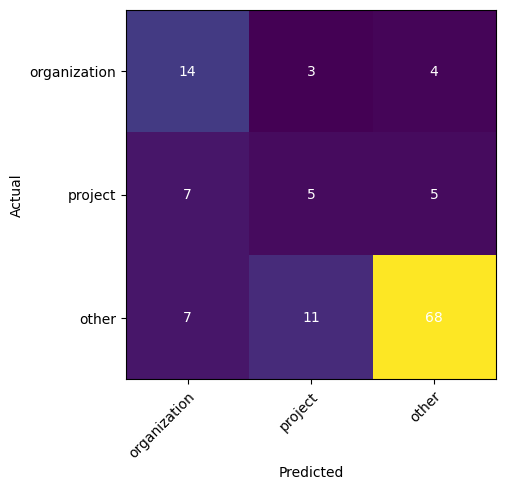

In [13]:
classes = ["organization", "project", "other"]

fig, ax = plt.subplots()
im = ax.imshow(conf_mat)

ax.set_xticks(np.arange(len(classes)), labels=classes)
ax.set_yticks(np.arange(len(classes)), labels=classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, conf_mat[i, j],
                       ha="center", va="center", color="w")

In [14]:
FP = conf_mat.sum(axis=0) - np.diag(conf_mat)  
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP+FN)
# Fall out or false positive rate
FPR = FP / (FP+TN)
TPR, FPR

(array([0.66666667, 0.29411765, 0.79069767]),
 array([0.13592233, 0.13084112, 0.23684211]))

In [15]:
np.mean(TPR), np.mean(FPR)

(0.5838273293813648, 0.16786851895185742)

In [16]:
test_data = first_paragraphs.iloc[test_indices]

In [17]:
results = pd.DataFrame({"labels": test_data["label"], 
                        "preds": test_data["prediction"], 
                        "id": test_data["postId"]})
results["pred_class"] = results.preds.map(class_map)
results["true_class"] = results.labels.map(class_map)

In [18]:
org2other = results[(results.true_class == "other") & (results.pred_class == "organization")]

In [19]:
idx = 1
print(dataset[dataset._id == org2other.id.iloc[idx]]["body"].values[0])



This is a first part of two-part post about effective altruism in the Czech Republic, describing its history and reflections on what worked.

I think it can be useful

\- to share experiences with building the EA community in a country where it did not exist (even if it is anecdotal evidence)

\- because we are working on several projects that have global or European ambitions, and we are happy to work together on them with you :)

\- because the perspective from Prague is sometimes different from Oxford or the Bay Area

Beginnings

The Czech Association for Effective Altruism (CZEA) was established relatively recently in the second half of 2016, by members of the local LessWrong community, but also with the participation of Radim Lacina from Oxford and Aleš Flidr from Harvard EA. Our first project was the organization of the EAGx Prague 2016 conference, with the main goal of increasing the number of effective altruists in the country. The second activity we have been spending much e